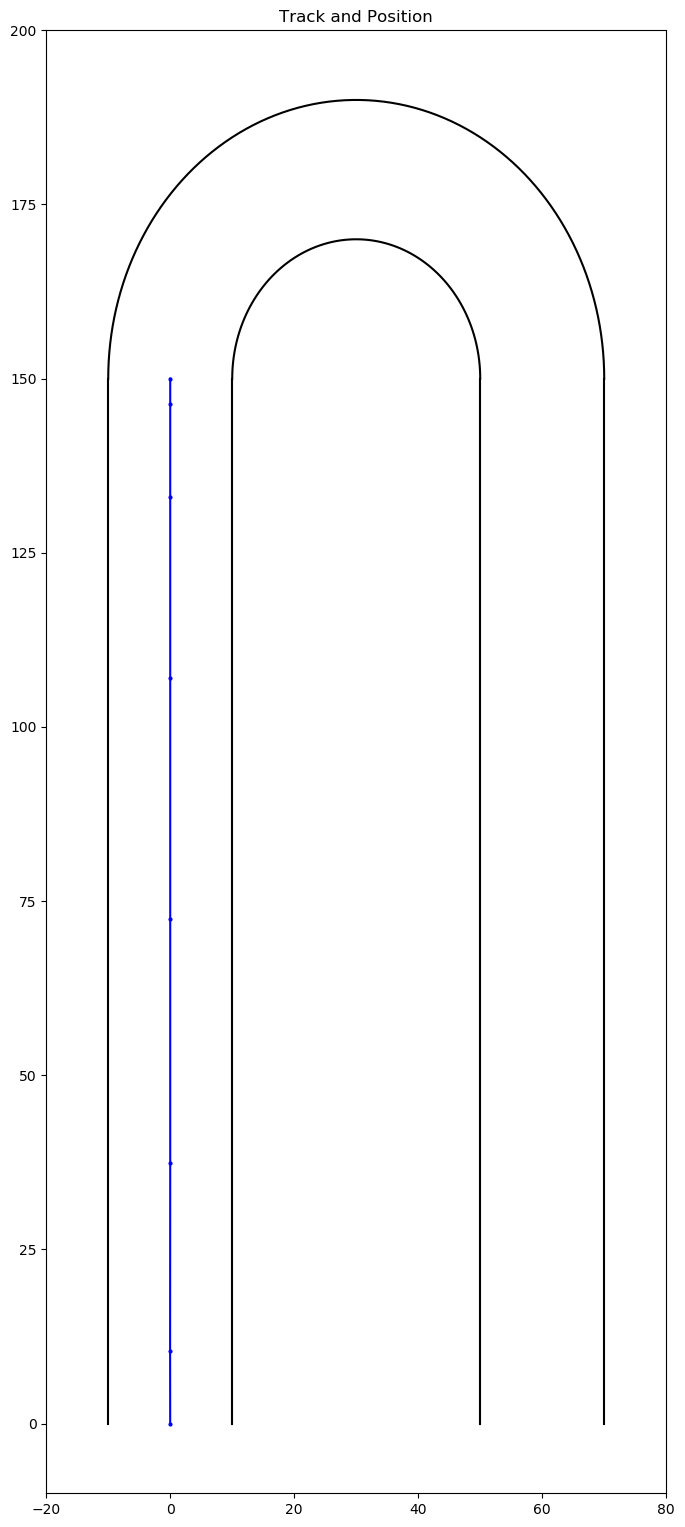

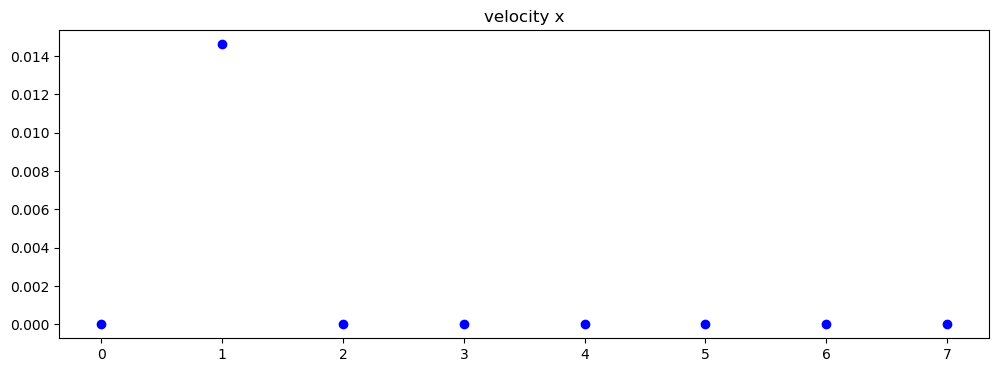

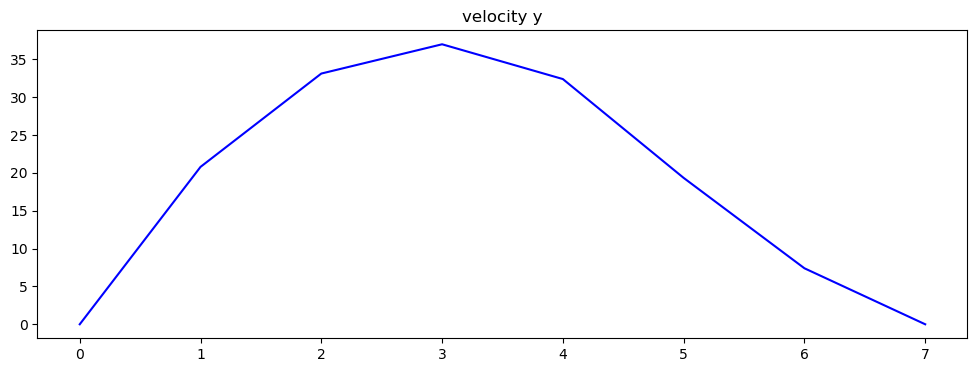

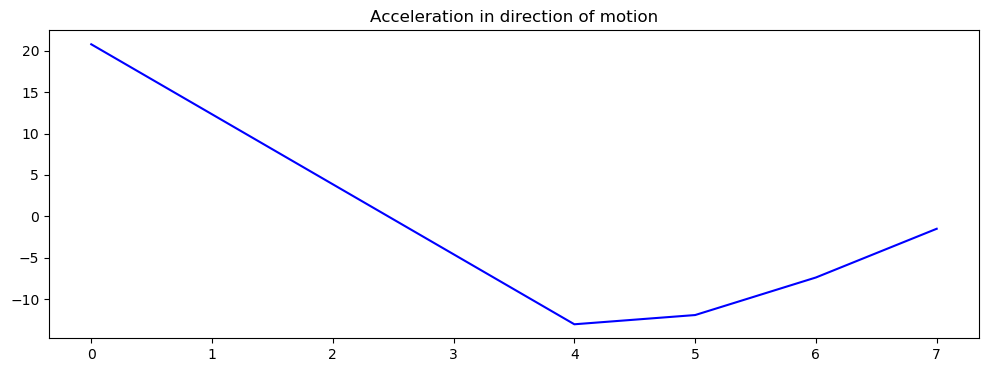

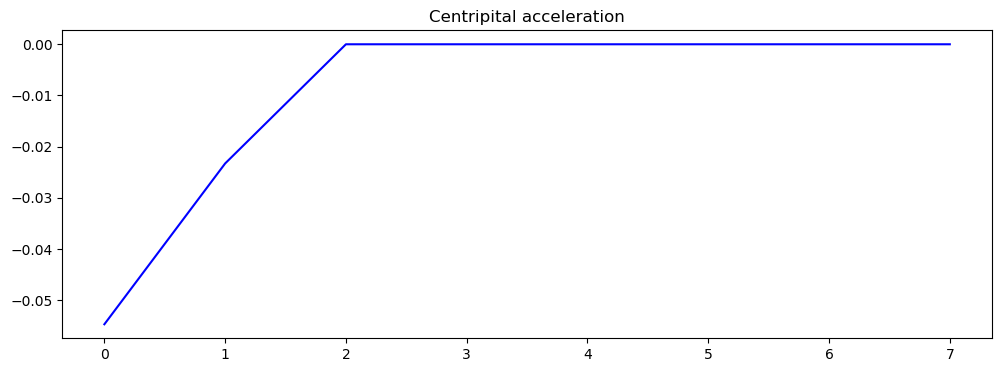

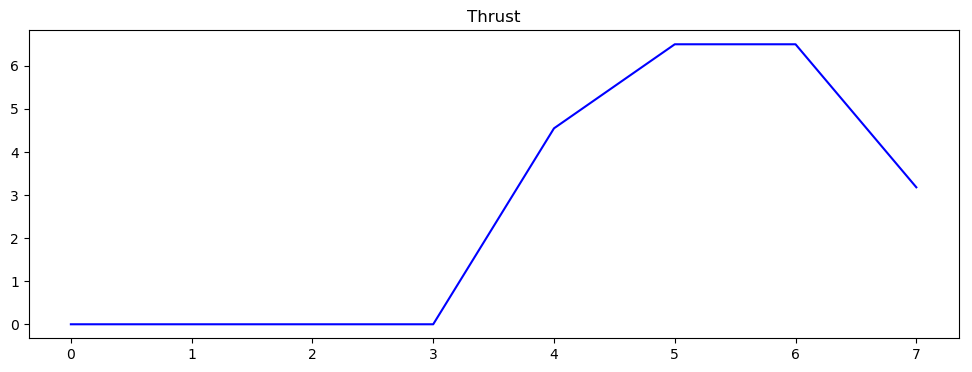

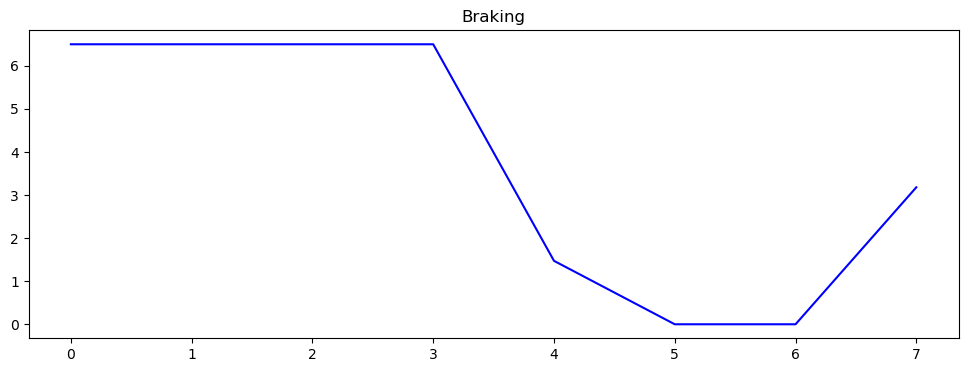

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1415abfd0>

In [52]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt


## Tyre specs
coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 6.5 # max acc in m/sec^2
maxv = 55.55 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side


# k =1000 # number of waypoints
k = 8
m = Model(solver = IpoptSolver(print_level=0))


## Basic variables and their constraints
@variable(m, P[1:2,1:k])  # resulting position in x,y
@variable(m, 0 <= v[1:2,1:k] <= maxv)  # vector resulting velocity
@variable(m, 0 <= Thrust[1:k] <= maxacc)  # thruster input
@variable(m, 0 <= Braking[1:k] <= maxacc)  # braking input
@variable(m, Acc[1:2,1:k]) #Acc[1] is in direction of motion not in x direction, Acc[2] is in direction perpendicular to direction of motion                                   
@constraint(m, Acc[2,1:k] .>= -cofla*g)
@constraint(m, Acc[2,1:k] .<= cofla*g)
# for i in 1:k
#     @NLconstraint(m, Acc[1,k]/Acc[2,k]*1.57 <= maxTu)
#     @NLconstraint(m, Acc[1,k]/Acc[2,k]*1.57 >= -maxTu)
# end


## Track boundaries variables and constraints (Plot dimensions are in kilometers, -10km to 70 km) 
# @constraint(m, -10000 .<= P[1,:] .<= 70000)
# for t in 1:k
#     @NLconstraint(m, P[2,t] <= 150000 + sqrt(40000^2 - P[1,t]^2))
# end
@constraint(m, -10 .<= P[1,:] .<= 70)
for t in 1:k
    @NLconstraint(m, P[2,t] <= 150 + sqrt(40^2 - P[1,t]^2))
end


## Start ad Finish constraints
startPos = [0,0]
# finishPos = [0,15000]
finishPos = [0,150]
startVel = [0,0]
finishVel = [0,0]
finishAcc = [0,0]
@constraint(m, P[:,1] .== startPos)
@constraint(m, P[:,k] .== finishPos)
@constraint(m, v[:,1] .== startVel)
@constraint(m, v[:,k] .== finishVel)
@constraint(m, Acc[:,k] .== finishAcc)
# @NLexpression(m, finishDistance, sqrt(sum((P[i,k]-finishPos[i])^2 for i in 1:2)))


## motion constraints
for t in 1:k-1
#     @NLconstraint(m, v[1,t+1] == v[1,t] + Acc[1,t]*v[1,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))  #     @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * cos(atan(v[2,t]/v[1,t])))
#     @NLconstraint(m, v[2,t+1] == v[2,t] + Acc[1,t]*v[2,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))   #     @constraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * sin(atan(v[2,t]/v[1,t])))
    @NLconstraint(m, v[1,t+1] == v[1,t] + Acc[1,t]*v[1,t]/sqrt((v[1,t]^2)+(v[2,t]^2)) + Acc[2,t]*v[2,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))  # turning + straight
    @NLconstraint(m, v[2,t+1] == v[2,t] + Acc[1,t]*v[2,t]/sqrt((v[1,t]^2)+(v[2,t]^2)) + Acc[2,t]*v[1,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))  # turning + straight
    @NLconstraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*Acc[1,t]*v[1,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))  #     @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*cos(atan(v[2,t]/v[1,t])))
    @NLconstraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*Acc[1,t]*v[2,t]/sqrt((v[1,t]^2)+(v[2,t]^2)))  #     @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*sin(atan(v[2,t]/v[1,t])))
    @constraint(m, Acc[1,t+1] == Acc[1,t] + Thrust[t] - Braking[t] - (coflo*g))
end
# @NLobjective(m, Min, finishDistance)
# @objective(m, Min, sum(Thrust))
solve(m)


## Plotting everything
#Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 30 + 40*cos.(rad)
y = 150 +40*sin.(rad)
x1 = 30 + 20*cos.(rad)
y1 = 150 +20*sin.(rad)
Llinex = [-10, -10]
Lliney = [0, 150]
LMlinex = [10,10]
LMliney = [0,150]
RMlinex = [50, 50]
RMliney = [0,150]
Rlinex = [70,70]
Rliney = [0,150]
figure(figsize=(8,19))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
# axis((-20000,80000,-10000,200000));
axis((-20,80,-10,200));

figure(figsize=(12,4))
title("velocity x")
plot( getvalue(v[1,:]), "b.", markersize=12 )

figure(figsize=(12,4))
title("velocity y")
plot( getvalue(v[2,:]), "b-", markersize=12 )

figure(figsize=(12,4))
title("Acceleration in direction of motion")
plot( getvalue(Acc[1,:]), "b-", markersize=12 )

figure(figsize=(12,4))
title("Centripital acceleration")
plot( getvalue(Acc[2,:]), "b-", markersize=12 )

figure(figsize=(12,4))
title("Thrust")
plot( getvalue(Thrust), "b-", markersize=12 )

figure(figsize=(12,4))
title("Braking")
plot( getvalue(Braking), "b-", markersize=12 )